### **■ 유통 판매량 예측 및 재고 최적화**
# **단계 3: 모델링 및 비즈니스 평가**

<img src = "https://github.com/Jangrae/img/blob/master/store.png?raw=true" width=800, align="left"/>

# **⏰ 수행 과제**

다음과 같은 과정으로 프로젝트를 진행합니다.

#### **1. 환경 설정**
- 이후 진행에 필요한 환경 설정을 수행합니다.

#### **2. 4차 모델링**
- Random Forest, LigntGBM 알고리즘으로 모델링합니다.
- 이번에는 하이퍼파라미터 튜닝을 통해 모델의 성능을 높여봅니다.
- 변화되는 모델의 성능을 기록합니다.

#### **3. 파이프라인 구축**
- 새로 읽어온 데이터에 대해 모델이 예측핳 수 있는 형태의 데이터 셋을 만들어야 합니다.
- 이러한 데이터 셋을 만드는 파이프라인을 함수를 만들어 보세요.

#### **4. 최종 평가**
- 새로운 데이터에 대해 예측하고 성능을 평가합니다.
- 재고량을 평가하는 다음 함수를 활용해 비즈니스 관점의 평가를 수행하세요.
- 최종 평가 결과를 기록하고 비교합니다.

# **1. 환경 설정**

- 이후 진행에 필요한 환경 설정을 수행합니다.

## **(1) 경로 설정**

- 프로젝트 수행 환경에 맞게 파일 경로를 설정합니다.

### **1) 로컬 수행(Anaconda)**
- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [104]:
# 기본 경로
path = '../DX_미니프로젝트 5차_1일차 실습자료/'

### **2) 구글 콜랩 수행**

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [105]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

## **(2) 라이브러리 불러오기**

- 이후 사용할 라이브러리를 모두 불러옵니다.

In [106]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

- 모델이 예측한 결과를 시각화할 때 다음 함수를 활용합니다.

In [107]:
# 함수 만들기
def plot_model_result(y_train, y_val, y_pred):
    
    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    y_pred = pd.Series(y_pred.reshape(-1,), index=y_val.index)

    # 전체 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(2,1,1)
    plt.plot(y_train, label='y_train', color='tab:blue')
    plt.plot(y_val, label='y_val', color='tab:green')
    plt.plot(y_pred, label='y_pred', color='tab:orange')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'y_val', color='tab:green')
    plt.plot(y_pred, label = 'y_pred', color='tab:orange')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print('RMAE', mean_squared_error(y_val, y_pred, squared=False))
    print('MAE', mean_absolute_error(y_val, y_pred))
    print('MAPE', mean_absolute_percentage_error(y_val, y_pred))
    print('R2', r2_score(y_val, y_pred))

## **(3) 데이터 불러오기**

- 이후 분석 대상이 되는 파일을 불러오고 기본 정보를 확인합니다.

### **1) 데이터 불러오기**

- 이전 과정에서 저장한 pkl 파일을 불러옵니다.
- 데이터프레임 이름은 data03, data12, data42가 되게 합니다.
- 다음과 같은 형태의 구문으로 불러옵니다.
~~~
mydata = joblib.load(path + 'mydata.pkl')
~~~

In [108]:
data03 = joblib.load('data03.pkl')
data12 = joblib.load('data12.pkl')
data42 = joblib.load('data42.pkl')

### **2) 기본 정보 확인**

- 각 데이터의 기본 정보를 확인합니다.

In [109]:
data03.head()

,Date,Qty,CustomerCount,WeekDay,Month,WTI_Price,Target,City_CustCount,Category_Qty,Qty_Lag_1,Qty_Lag_7_mean
1,2014-01-02,9853.0,4422.0,Thursday,1.0,95.140000,15153.0,45969.0,176120.0,0.0,4926.500000
2,2014-01-03,8647.0,4167.0,Friday,1.0,94.400000,15606.0,42386.0,151502.0,9853.0,6166.666667
3,2014-01-04,15153.0,5341.0,Saturday,1.0,94.400000,7900.0,52293.0,222138.0,8647.0,8413.250000
4,2014-01-05,15606.0,5123.0,Sunday,1.0,94.400000,7188.0,49199.0,222012.0,15153.0,9851.800000
5,2014-01-06,7900.0,3917.0,Monday,1.0,93.973333,8800.0,39105.0,136433.0,15606.0,9526.500000


In [110]:
data12.head()

,Date,Qty,CustomerCount,WeekDay,Month,WTI_Price,Target,City_CustCount,Category_Qty,Qty_Lag_1,Qty_Lag_7_mean
1,2014-01-02,9647.0,4422.0,Thursday,1.0,95.140000,14188.0,45969.0,298620.320011,0.0,4823.500000
2,2014-01-03,8879.0,4167.0,Friday,1.0,94.400000,14490.0,42386.0,250953.870948,9647.0,6175.333333
3,2014-01-04,14188.0,5341.0,Saturday,1.0,94.400000,7614.0,52293.0,352348.306930,8879.0,8178.500000
4,2014-01-05,14490.0,5123.0,Sunday,1.0,94.400000,7124.0,49199.0,362852.115984,14188.0,9440.800000
5,2014-01-06,7614.0,3917.0,Monday,1.0,93.973333,8683.0,39105.0,233749.026011,14490.0,9136.333333


In [111]:
data42.head()

,Date,Qty,CustomerCount,WeekDay,Month,WTI_Price,Target,City_CustCount,Category_Qty,Qty_Lag_1,Qty_Lag_7_mean
1,2014-01-02,76.0,4422.0,Thursday,1,95.140000,78.0,45969.0,35336.643958,51.0,63.50
2,2014-01-03,74.0,4167.0,Friday,1,94.400000,88.0,42386.0,32032.468719,76.0,67.00
3,2014-01-04,78.0,5341.0,Saturday,1,94.400000,65.0,52293.0,34557.982838,74.0,69.75
4,2014-01-05,88.0,5123.0,Sunday,1,94.400000,78.0,49199.0,29491.302000,78.0,73.40
5,2014-01-06,65.0,3917.0,Monday,1,93.973333,73.0,39105.0,18564.406008,88.0,72.00


# **2. 4차 모델링**

- Random Forest, LigntGBM 알고리즘으로 모델링합니다.
- 모델링 과정에서 변수 이름은 **x_train, x_val, y_train, y_val, y_pred**을 사용합니다.
- 이번에는 **하이퍼파라미터 튜닝**을 통해 모델의 성능을 높여봅니다.
- **검증용 데이터**는 학습용 데이터에서 **최근 120일간**의 데이터를 사용합니다.
- 변화되는 모델의 성능을 기록합니다.

In [112]:
model_lr = 'LinearRegression'
model_rf = 'RandomForestRegressor'
model_lgbm = 'LGBMRegressor'

In [113]:
def model_set(data_num, select_model):
    target = ['Date', 'Target']
    x = data_num.drop(target, axis=1)
    y = data_num['Target']

    weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories=weekdays)
    x['Month'] = pd.Categorical(x['Month'], categories=months)
    x = pd.get_dummies(x, columns=['WeekDay','Month'], dtype=int)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=120, random_state=42, shuffle=False)

    if select_model == 'LinearRegression':
        model = LinearRegression()
        params = {}  # LinearRegression은 하이퍼파라미터가 없으므로 빈 딕셔너리로 설정
    elif select_model == 'RandomForestRegressor':
        model = RandomForestRegressor(random_state=42)
        params = {
            'n_estimators': [100, 300, 500],
            'max_depth': [None, 10, 30],
            'min_samples_split': [2, 5, 10]
        }
    elif select_model == 'LGBMRegressor':
        model = LGBMRegressor(random_state=42)
        params = {
            'n_estimators': [100, 200, 300],
            'max_depth': [-1, 10, 20],
            'learning_rate': [0.01, 0.05, 0.1]
        }
    else:
        raise ValueError("Unsupported model type. Please select from 'LinearRegression', 'RandomForestRegressor', or 'LGBMRegressor'.")

    grid_search = GridSearchCV(model, params, cv=5, n_jobs=2, verbose=2)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    pred = best_model.predict(x_val)

    return y_train, y_val, pred

## **(1) Random Forest 모델**

### **1) 상품: 3 - Beverage**

- GridSearchCV를 사용해 3번 상품에 대해 모델링하고 성능을 확인합니다..
- 모델 이름은 **model03_rdf**로 합니다.

In [115]:
model03_rdf = model_set(data03, model_rf)
y_train, y_val, pred = model03_rdf

Fitting 5 folds for each of 27 candidates, totalling 135 fits


#### - 모델이 예측한 결과를 시각화해 확인합니다.

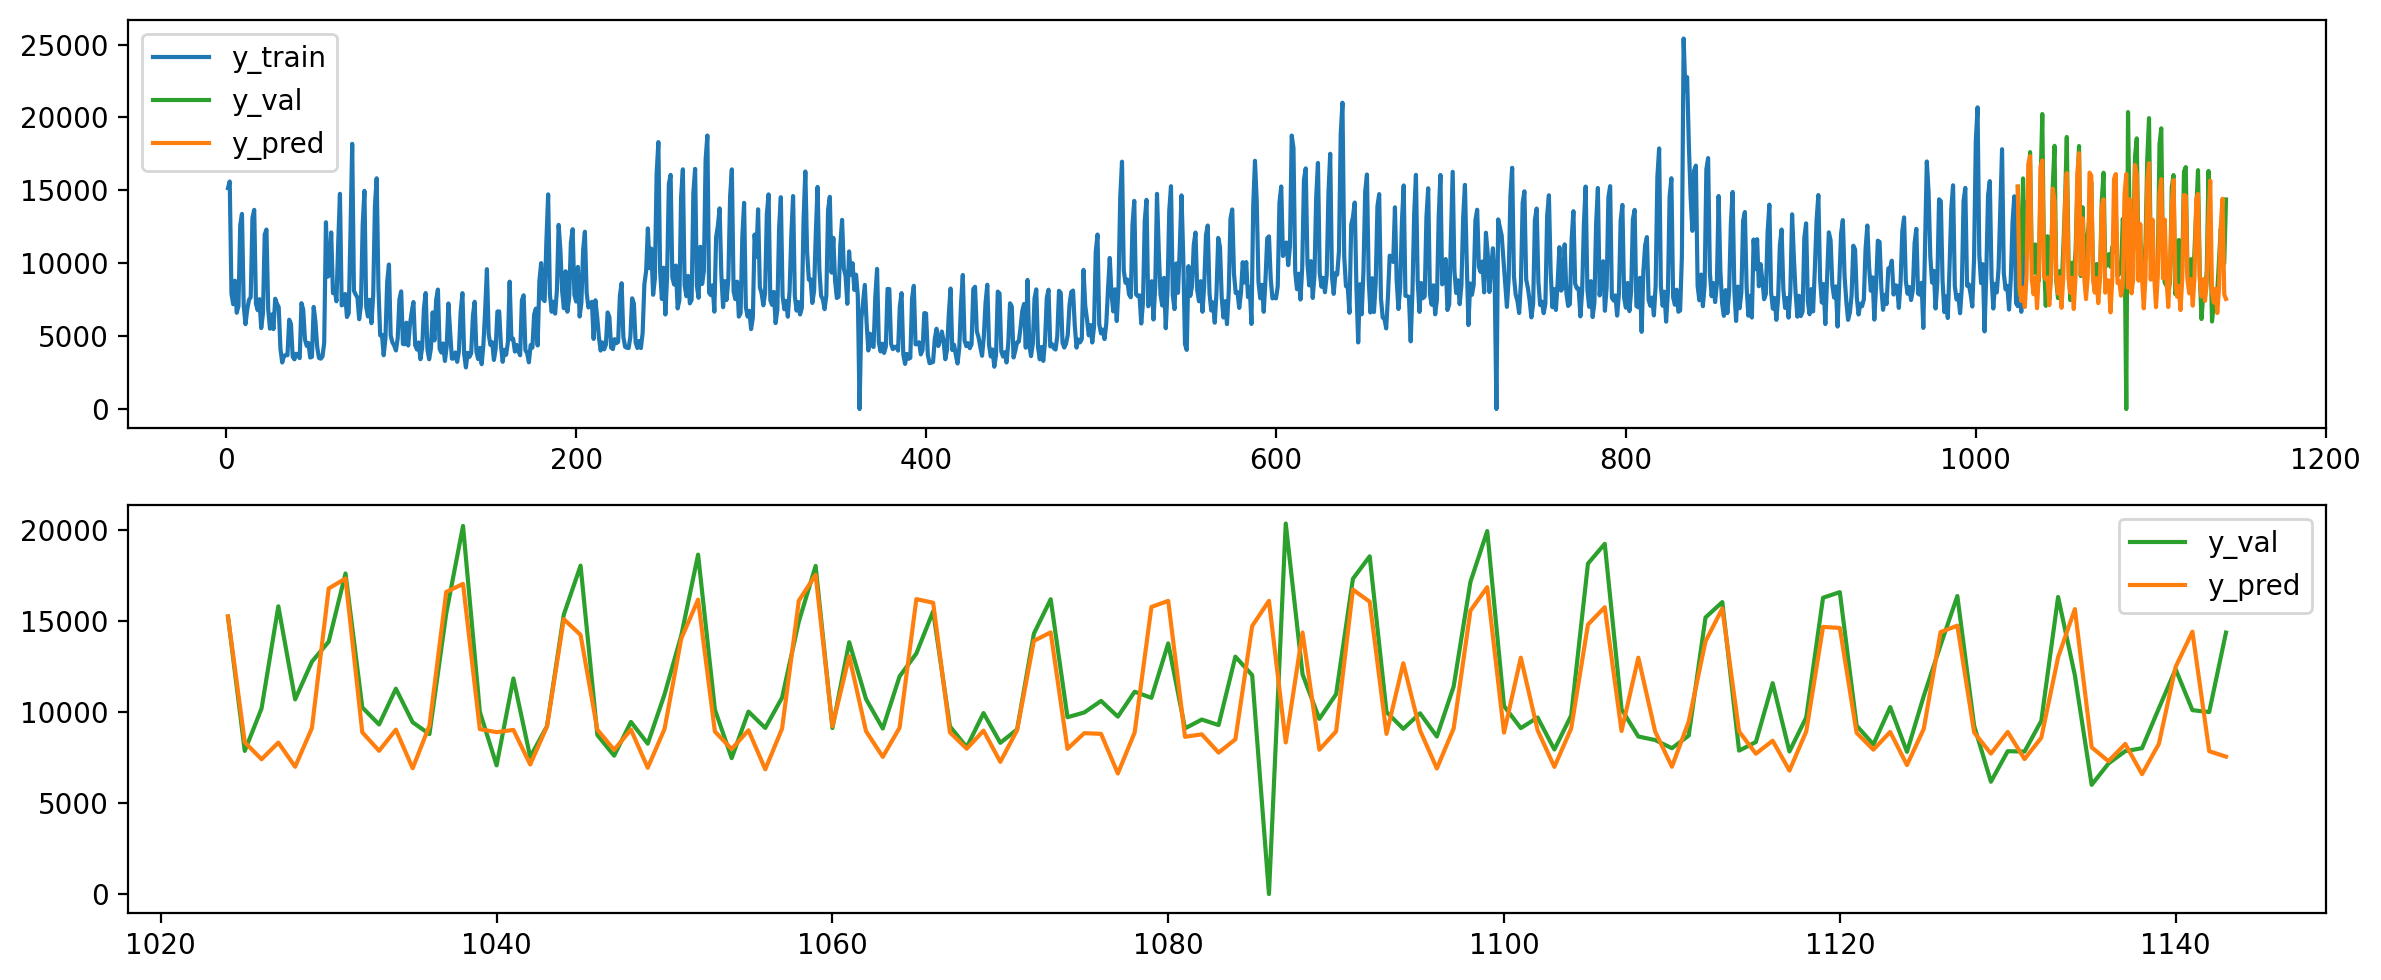

RMAE 2820.3459470846897
MAE 1877.3749357734557
MAPE 6.04946971721885e+17
R2 0.3887583735890551


In [116]:
plot_model_result(y_train, y_val, pred)

### **2) 상품: 12 - Milk**

- GridSearchCV를 사용해 12번 상품에 대해 모델링하고 성능을 확인합니다..
- 모델 이름은 **model12_rdf**로 합니다.

In [117]:
model12_rdf = model_set(data12, model_rf)
y_train, y_val, pred = model12_rdf

Fitting 5 folds for each of 27 candidates, totalling 135 fits


- 모델이 예측한 결과를 시각화해 확인합니다.

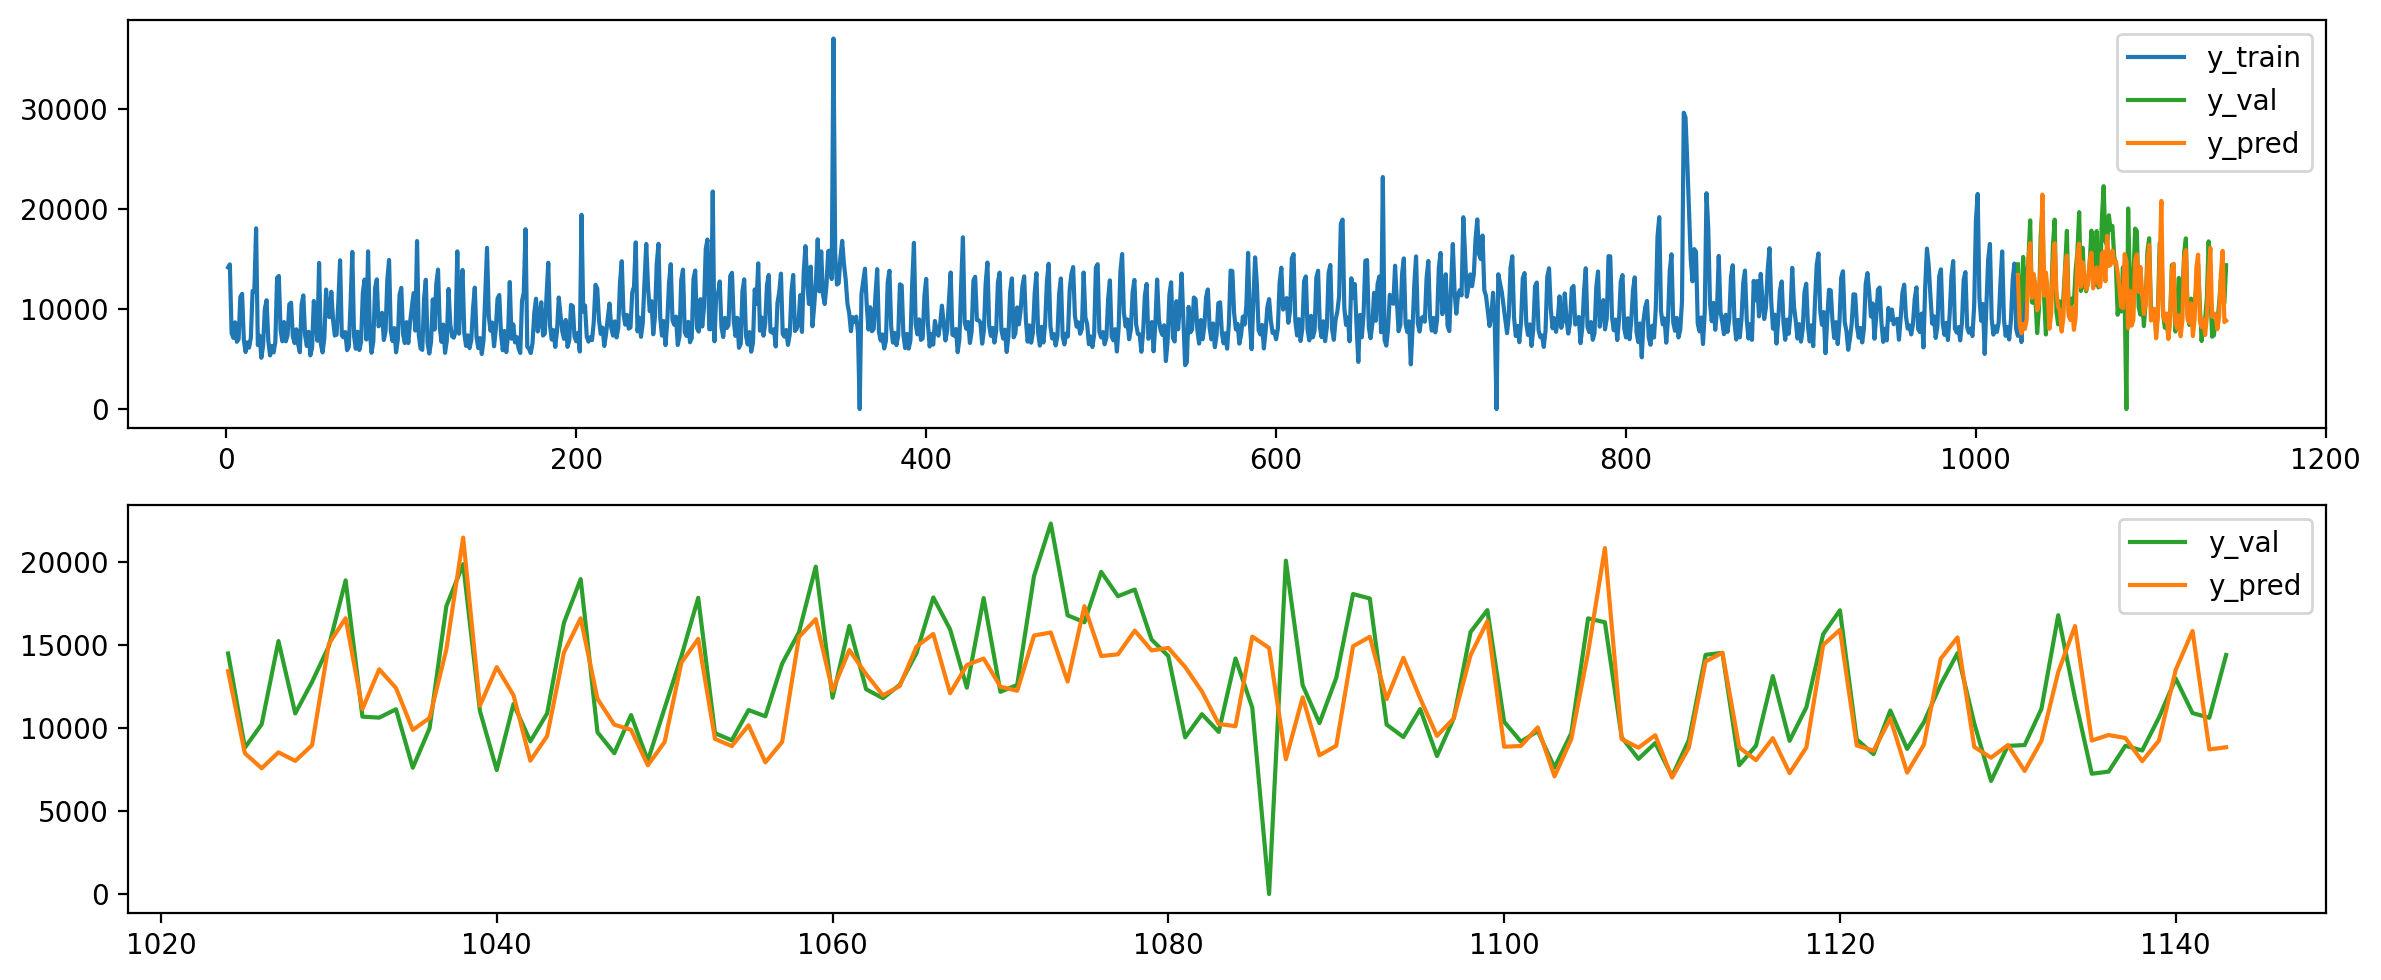

RMAE 2930.466740900188
MAE 1978.0896984151373
MAPE 5.562643522358835e+17
R2 0.3937217242410048


In [118]:
plot_model_result(y_train, y_val, pred)

### **3) 상품: 42 - Agricultural products**

- GridSearchCV를 사용해 42번 상품에 대해 모델링하고 성능을 확인합니다..
- 모델 이름은 **model42_rdf**로 합니다.

In [119]:
model42_rdf = model_set(data42, model_rf)
y_train, y_val, pred = model42_rdf

Fitting 5 folds for each of 27 candidates, totalling 135 fits


- 모델이 예측한 결과를 시각화해 확인합니다.

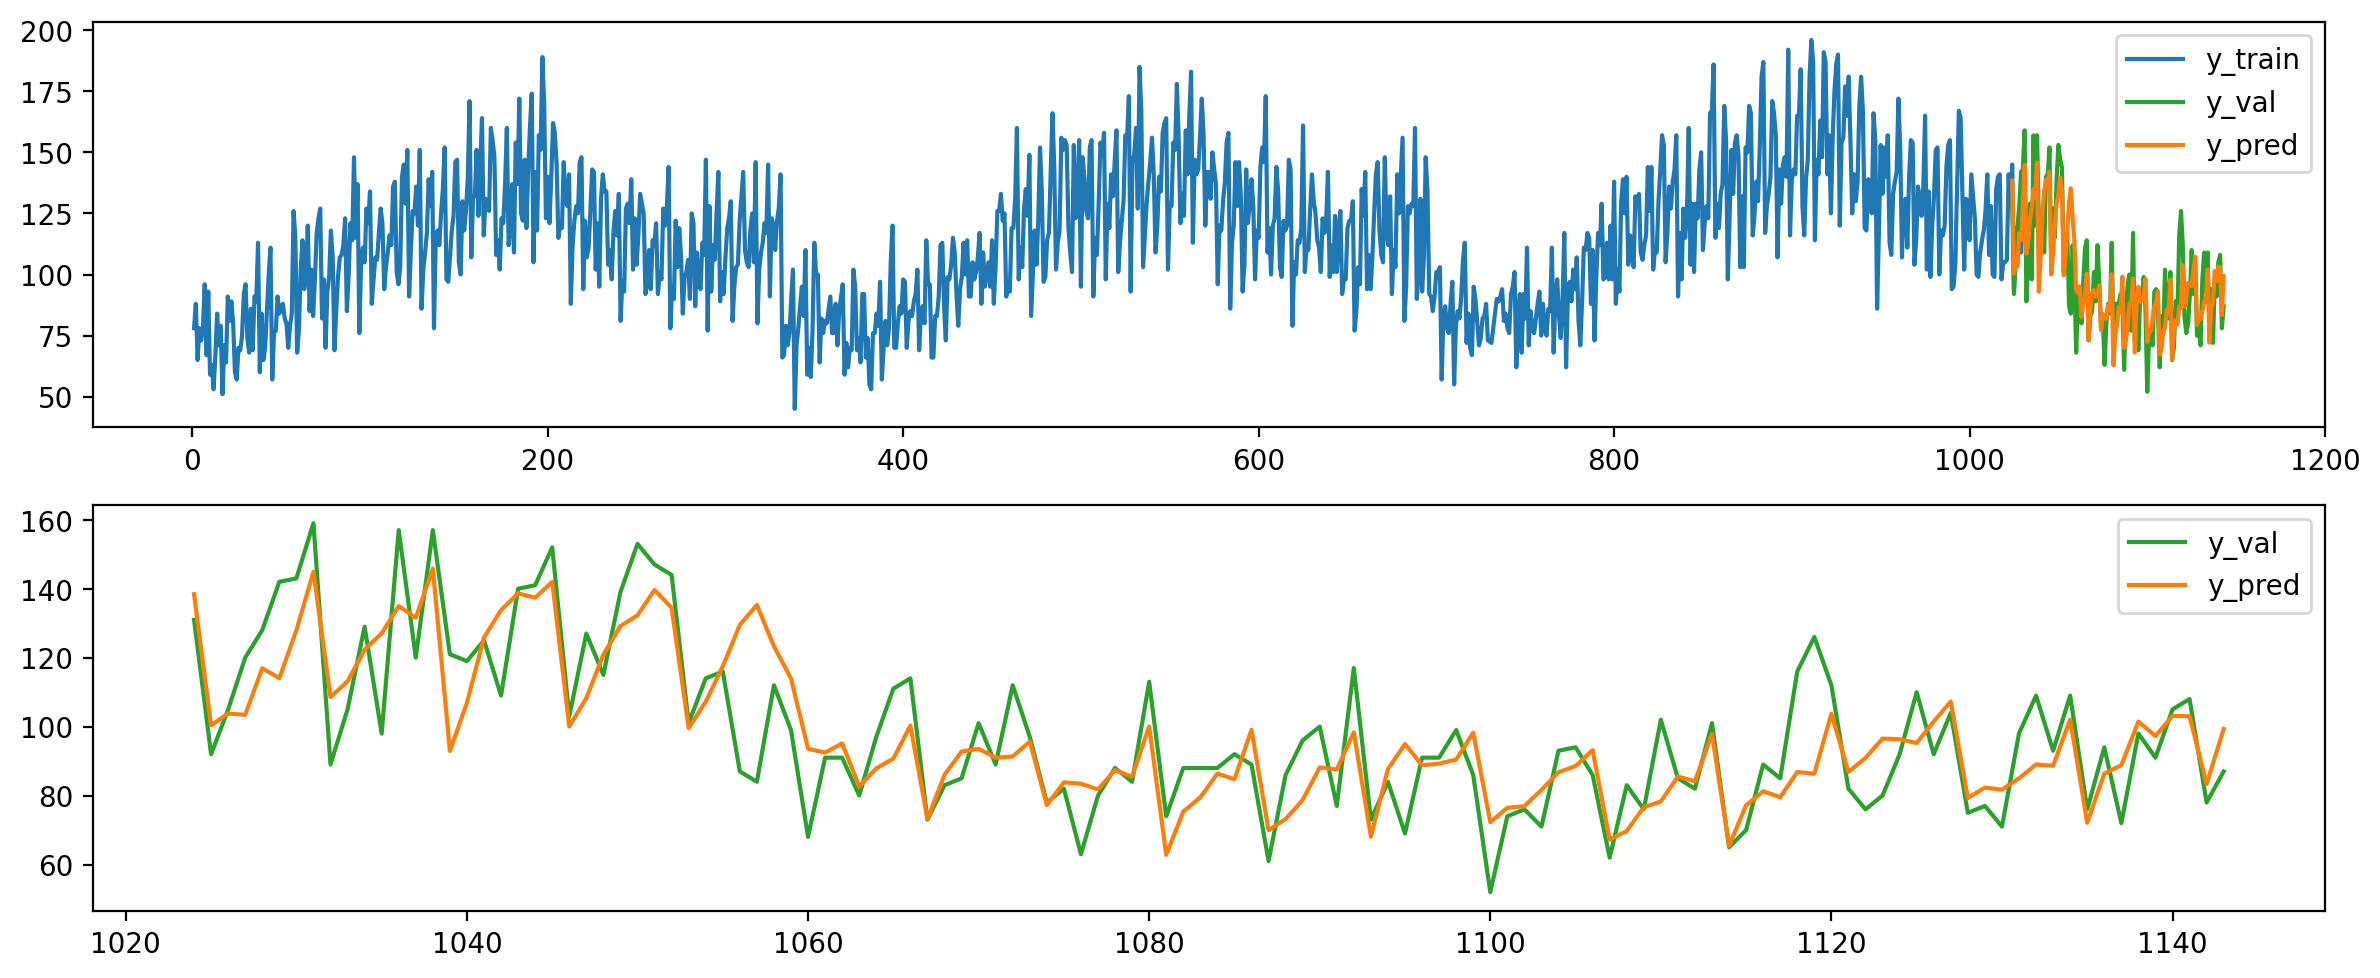

RMAE 13.793506096246736
MAE 10.337154223007747
MAPE 0.1076308314407223
R2 0.6472150656526131


In [120]:
plot_model_result(y_train, y_val, pred)

## **(2) LightGBM 모델**

### **1) 상품: 3 - Beverage**

- GridSearchCV를 사용해 3번 상품에 대해 모델링하고 성능을 확인합니다..
- 모델 이름은 **model03_lgb**로 합니다.

In [121]:
model03_lgb = model_set(data42, model_lgbm)
y_train, y_val, pred = model03_lgb

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 26
[LightGBM] [Info] Start training from score 114.990234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

- 모델이 예측한 결과를 시각화해 확인합니다.

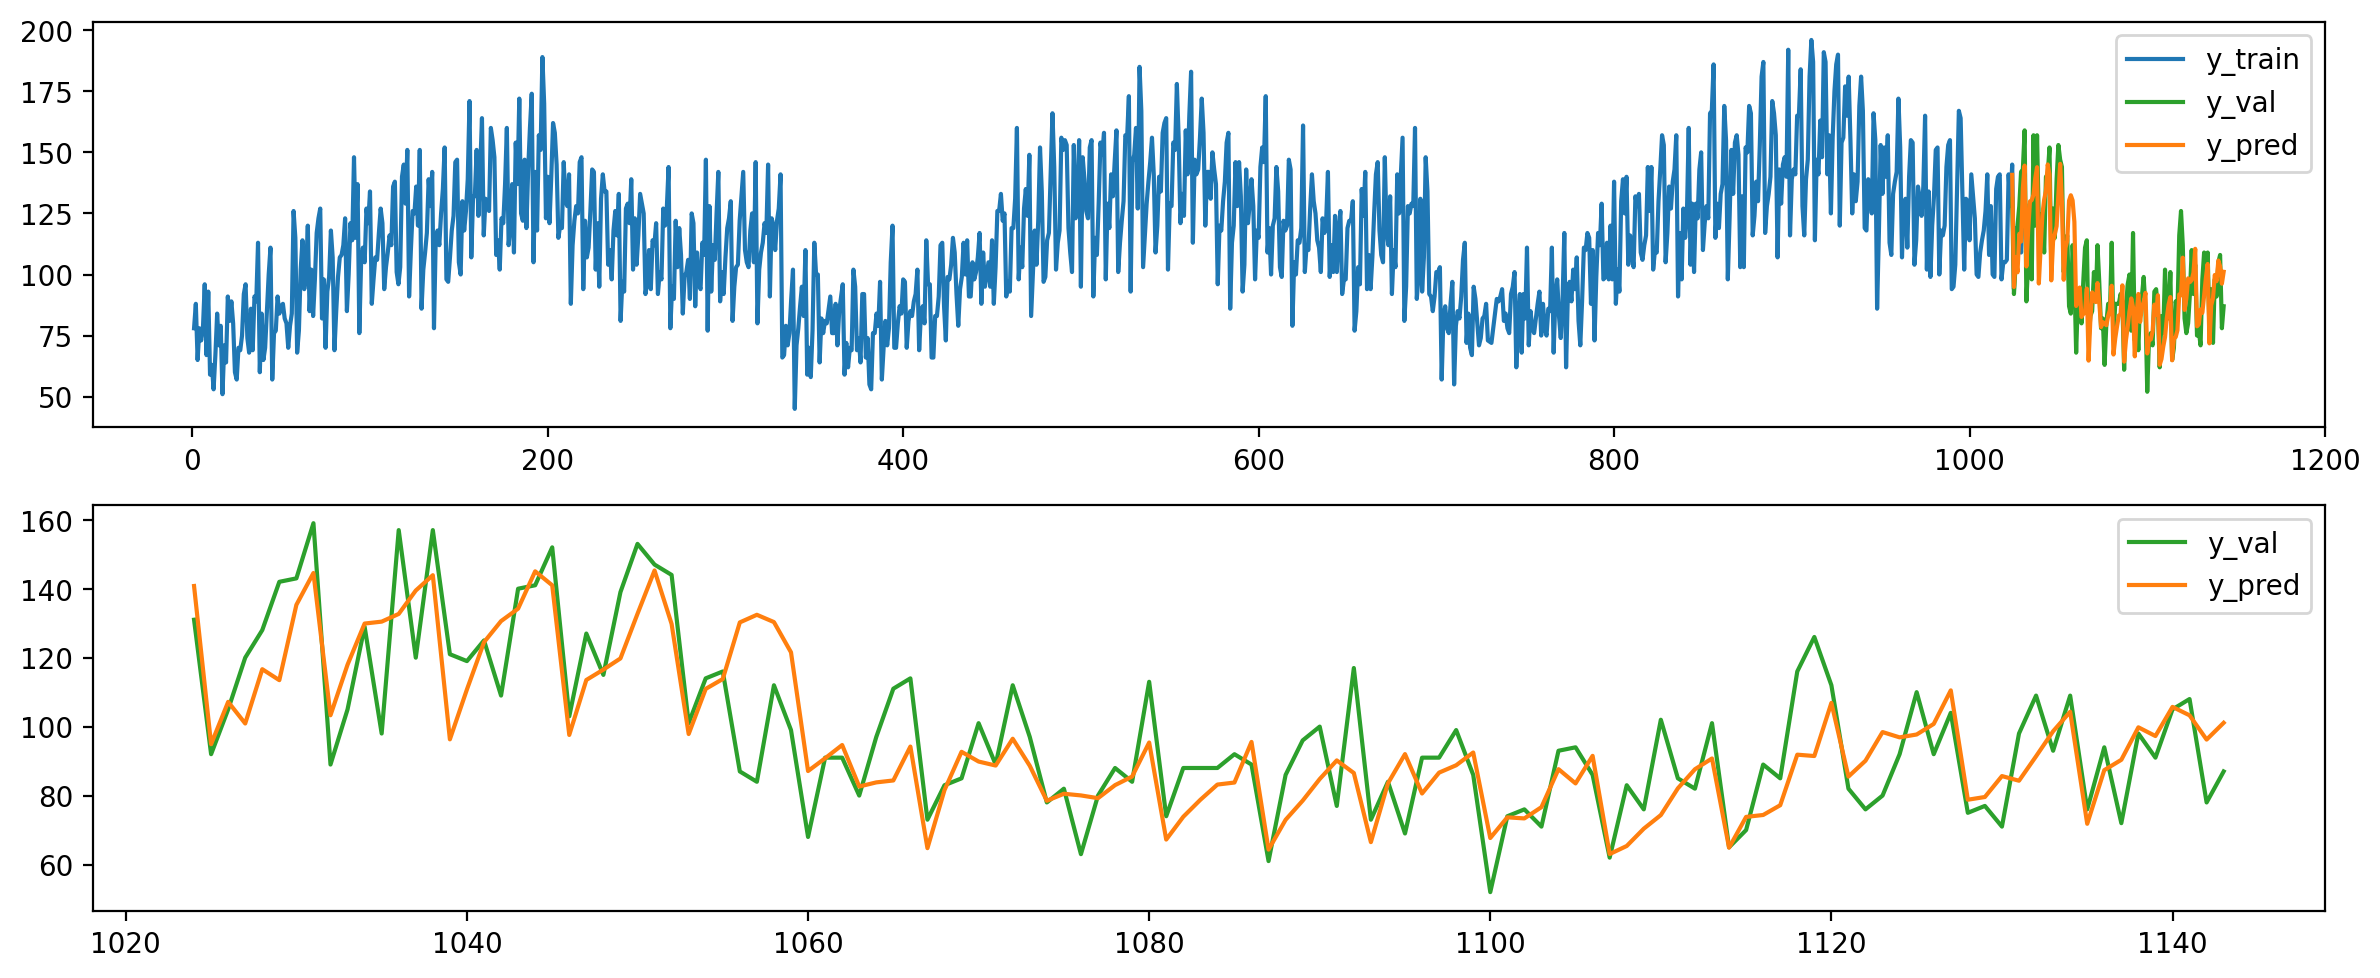

RMAE 14.21788660440731
MAE 10.868870369747851
MAPE 0.11194073533104056
R2 0.6251730747602102


In [122]:
plot_model_result(y_train, y_val, pred)

### **2) 상품: 12 - Milk**

- GridSearchCV를 사용해 12번 상품에 대해 모델링하고 성능을 확인합니다..
- 모델 이름은 **model12_lgb**로 합니다.

In [123]:
model12_lgb = model_set(data12, model_lgbm)
y_train, y_val, pred = model12_lgb

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 26
[LightGBM] [Info] Start training from score 9732.079140
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


- 모델이 예측한 결과를 시각화해 확인합니다.

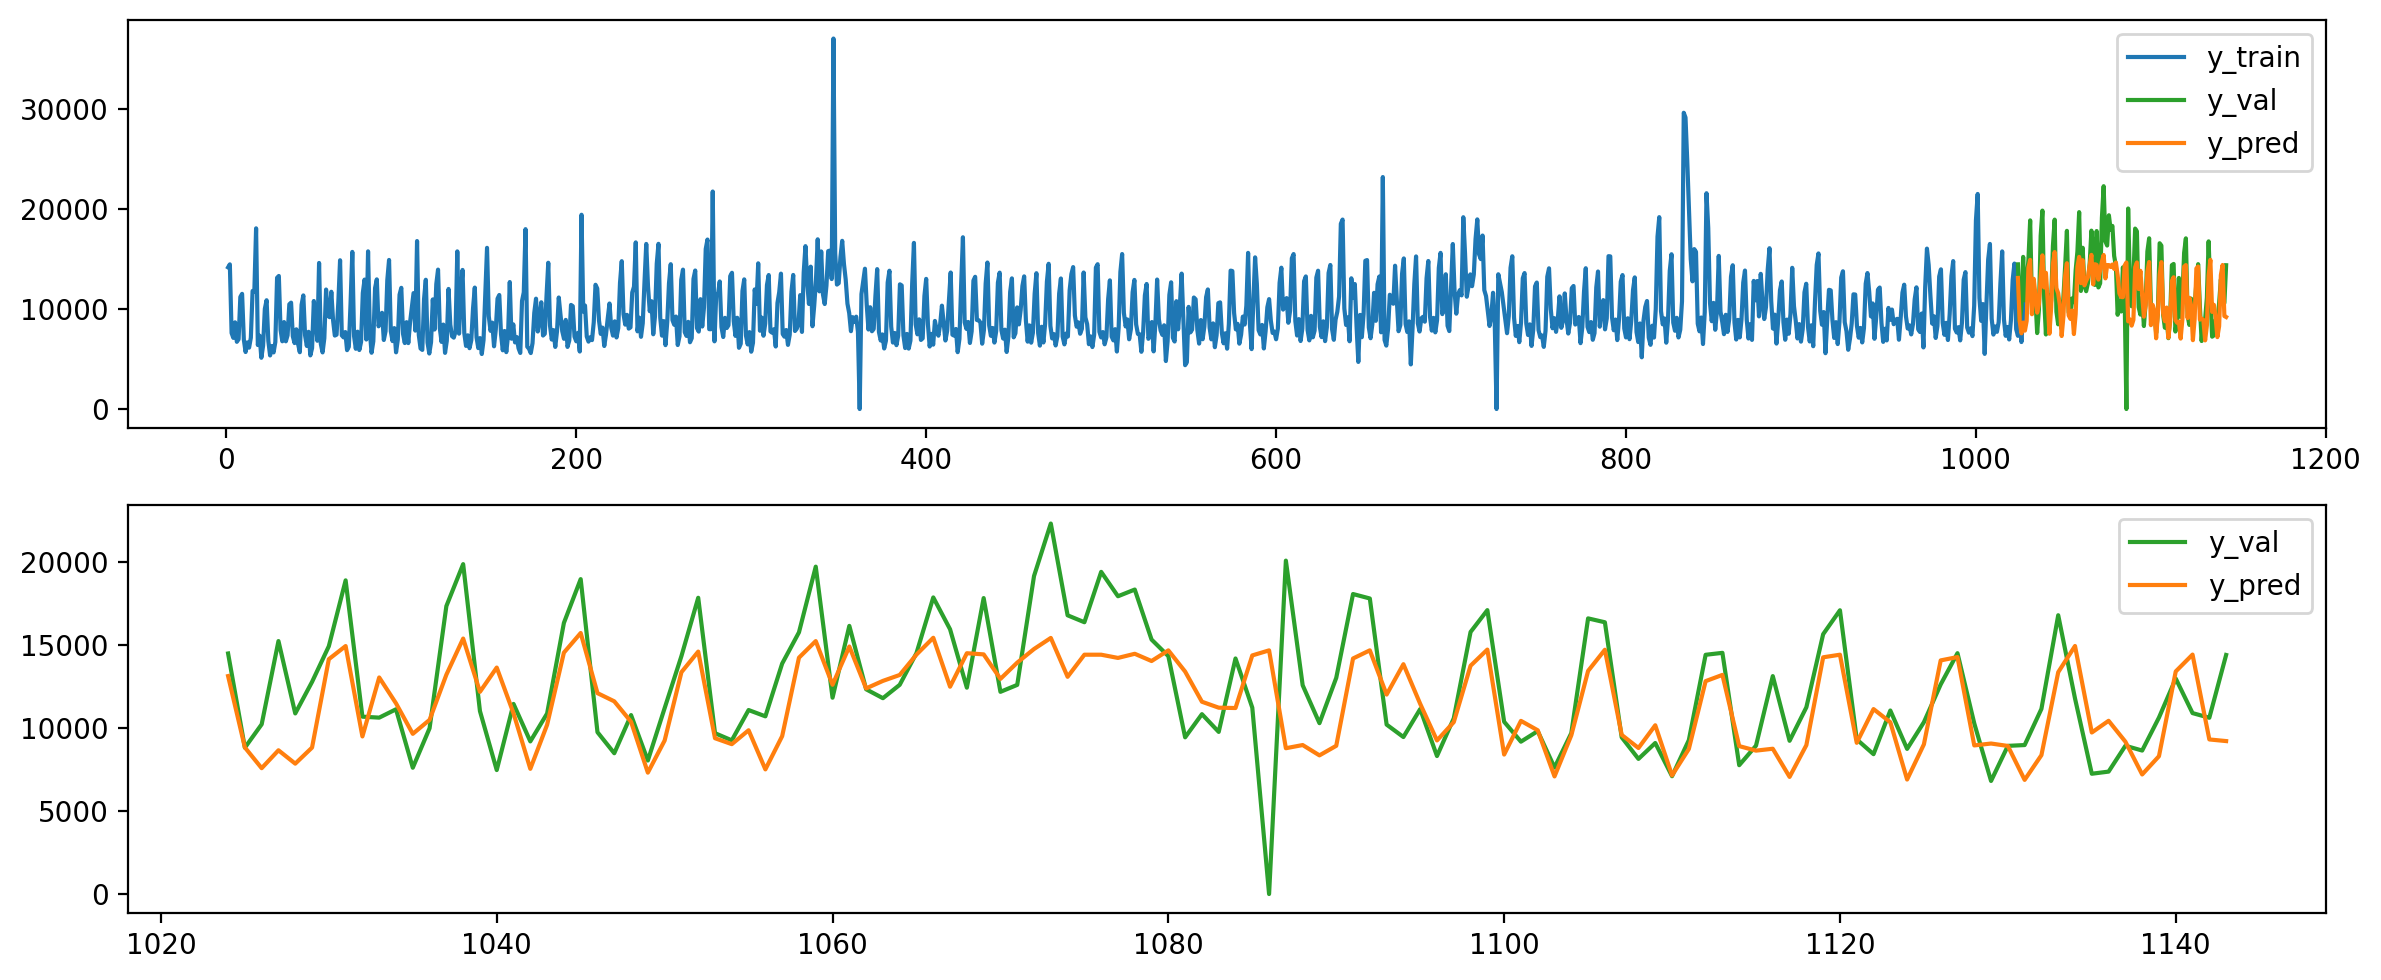

RMAE 3054.56074173482
MAE 2235.85709745525
MAPE 5.508296130234845e+17
R2 0.3412874394104025


In [124]:
plot_model_result(y_train, y_val, pred)

### **3) 상품: 42 - Agricultural products**

- GridSearchCV를 사용해 42번 상품에 대해 모델링하고 성능을 확인합니다..
- 모델 이름은 **model42_lgb**로 합니다.

In [125]:
model42_lgb = model_set(data42, model_lgbm)
y_train, y_val, pred = model42_lgb

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 26
[LightGBM] [Info] Start training from score 114.990234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

- 모델이 예측한 결과를 시각화해 확인합니다.

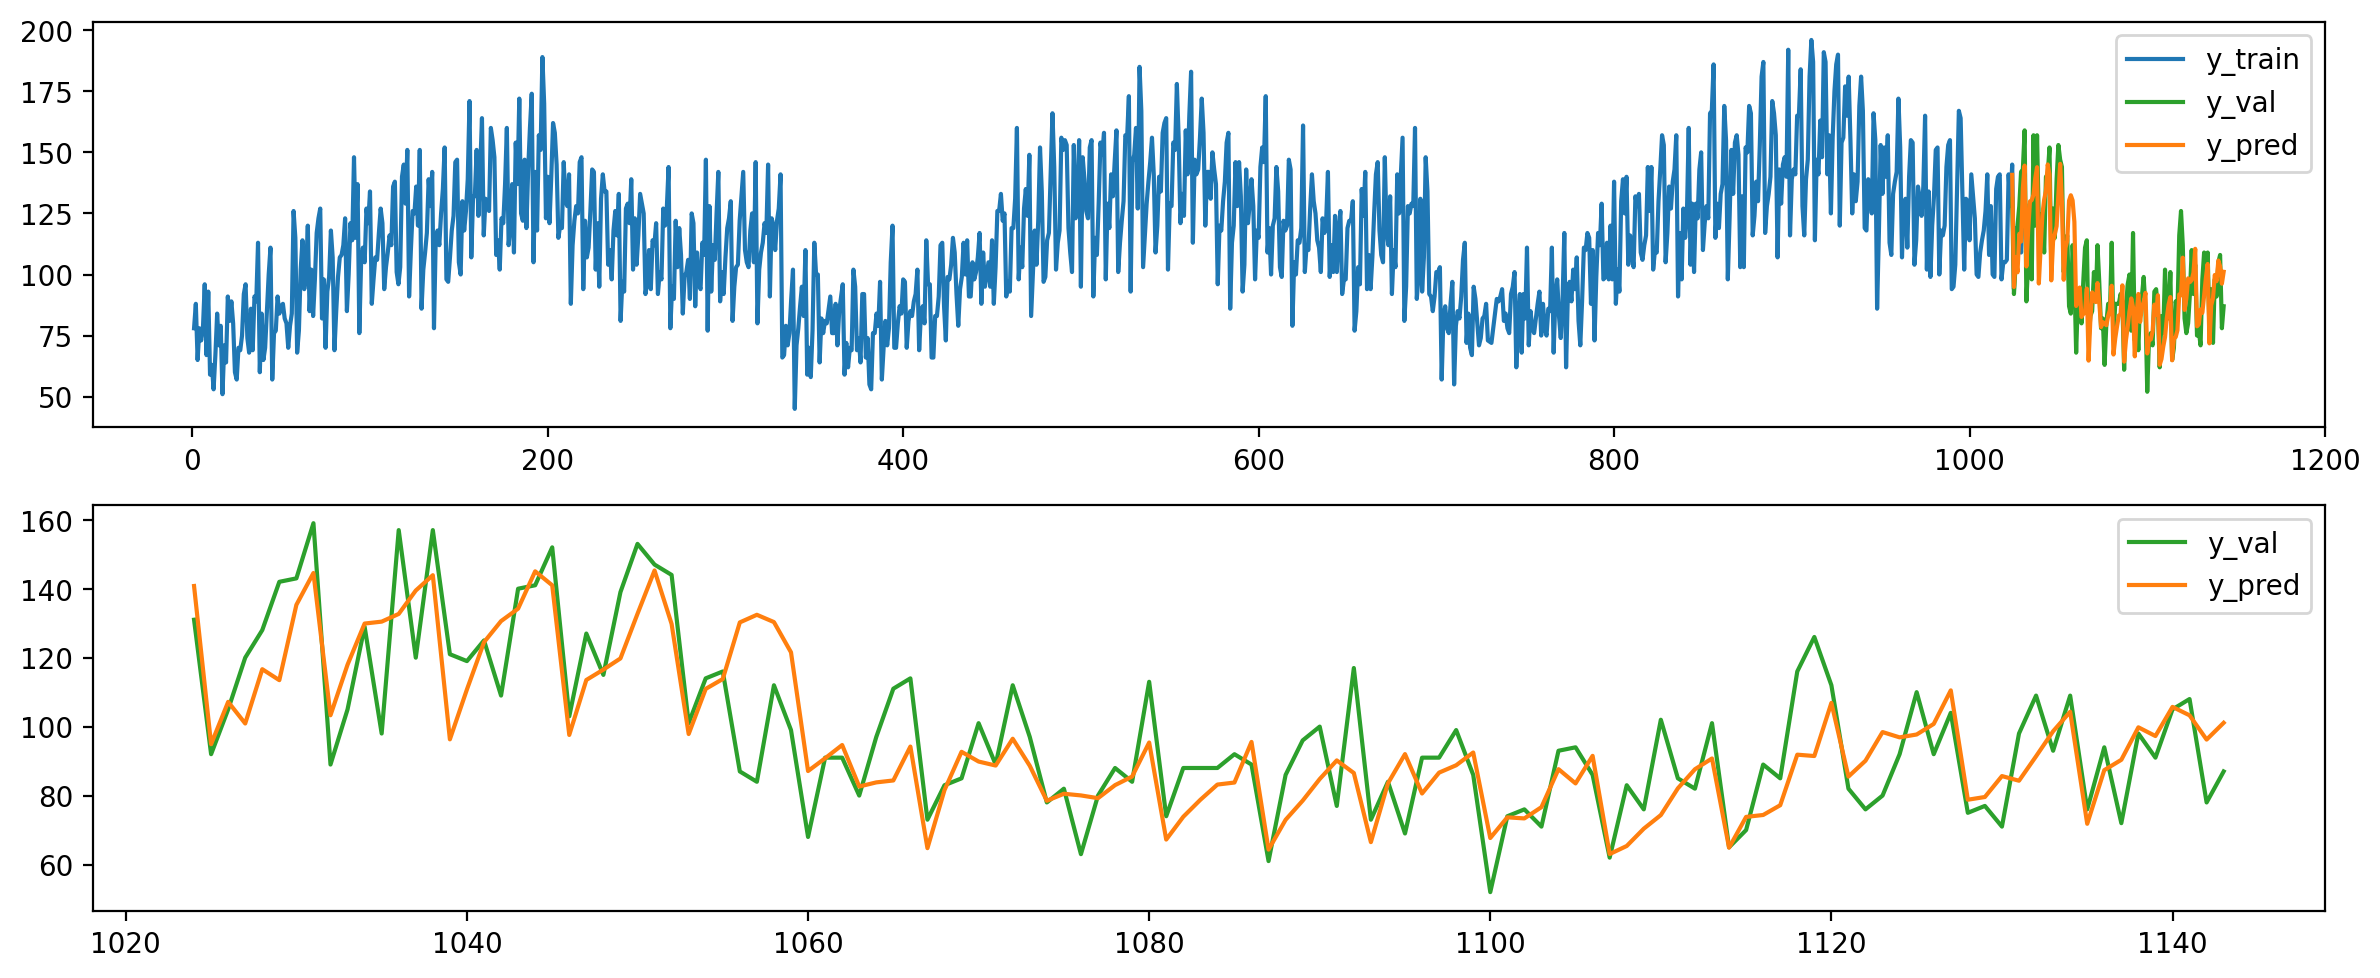

RMAE 14.21788660440731
MAE 10.868870369747851
MAPE 0.11194073533104056
R2 0.6251730747602102


In [126]:
plot_model_result(y_train, y_val, pred)

# **3. 파이프라인 구축**

- 새로 읽어온 데이터에 대해 모델이 예측핳 수 있는 형태의 데이터 셋을 만들어야 합니다.
- 이러한 데이터 셋을 만드는 파이프라인을 함수를 만들어 보세요.

## **(1) 새로운 데이터 불러오기**

- 평가에 사용할 새로운 데이터를 불러옵니다.
- 데이터프레임 이름은 다음과 같이 통일합니다.
    - sales: 판매 정보
    - orders: 고객 방문수
    - oil_price: 휘발유 가격
    - stores: 매장 정보
    - products: 상품 정보

In [127]:
# 데이터 불러오기
sales = pd.read_csv('sales_test.csv')
orders = pd.read_csv('orders_test.csv')
oil_price = pd.read_csv('oil_price_test.csv')
stores = pd.read_csv(path + 'stores.csv')
products = pd.read_csv(path + 'products.csv')

In [128]:
# datetime 형으로 변환
sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

## **(2) 데이터 파이프라인 구축**

- 다음과 같은 처리를 수행하는 파이프라인이 되어야 합니다.
    - 입력: sales_data, orders_data, oil_price_data, Product_ID
    - 처리:
        - 머신러닝 모델에 전달할 수 있는, 즉 x_train, x_val과 동일한 형태의 데이터 셋 만들기
        - 결측치 처리, 가변수화, 변수 제거, 변수 추가 등 일괄 처리
    - 출력: 전처리 완료된 데이터 프레임
    

In [129]:
from sklearn.pipeline import Pipeline

def prepare_data_pipeline(Product_ID):
    # Basic Data Preparation
    leadtime = products.loc[products['Product_ID'] == Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID), ['Date', 'Qty']]
    temp2 = orders.loc[orders['Store_ID'] == 44, ['Date', 'CustomerCount']]
    temp3 = pd.merge(temp1, temp2, on='Date', how='left')

    # Feature Engineering
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month

    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'].isin(Product_IDs))]
    temp4 = temp4.groupby(by='Date', as_index=False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, on='Date', how='left')

    City = stores.loc[stores['Store_ID'] == 44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City'] == City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)]
    temp5 = temp5.groupby('Date', as_index=False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, on='Date', how='left')

    temp3 = temp3.interpolate(method='linear')
    temp3 = temp3.fillna(method='bfill')

    temp3['Qty_Lag_2_mean'] = temp3['Qty'].rolling(2, min_periods=1).mean()
    temp3['Qty_Lag_7_mean'] = temp3['Qty'].rolling(7, min_periods=1).mean()
    temp3['Qty_Lag_14_mean'] = temp3['Qty'].rolling(14, min_periods=1).mean()

    # Target Addition
    temp3['Target'] = temp3['Qty'].shift(-leadtime)
    temp3.dropna(inplace=True)

    # Encoding Categorical Features
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    temp3['WeekDay'] = pd.Categorical(temp3['WeekDay'], categories=weekdays)
    temp3['Month'] = pd.Categorical(temp3['Month'], categories=months)
    temp3 = pd.get_dummies(temp3, columns=['WeekDay', 'Month'], dtype=int)

    # Train-Test Split
    target = ['Date', 'Target']
    x = temp3.drop(target, axis=1)
    y = temp3['Target']

    test_size = min(0.2, 120 / len(x))  # Set the test_size to 20% of the data or 120 samples, whichever is smaller

    # Creating a pipeline
    pipeline = Pipeline([
        ('preprocessing', None),  # Placeholder for preprocessing steps
        ('splitting', train_test_split(x, y, test_size=test_size, random_state=42, shuffle=False))
    ])

    return pipeline


In [130]:
# Usage example:
pipeline = prepare_data_pipeline(3)
x_train, x_val, y_train, y_val = pipeline.named_steps['splitting']

In [131]:
model = LinearRegression()
model.fit(x_train, y_train)
pred = model.predict(x_val)

# **4. 최종 평가**

- 새로운 데이터에 대해 예측하고 성능을 평가합니다.
- 재고금액을 평가하는 다음 함수를 활용해 비즈니스 관점의 평가를 수행하세요.
- 최종 평가 결과를 기록하고 비교합니다.

In [132]:
# 재고량 평가 함수 만들기
def inv_simulator(y, pred, safe_stock, price):
    
    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y': y.reshape(-1,), 'pred': pred.reshape(-1,).round()})
    temp['y'] = temp['y'].astype(int)
    temp['pred'] = temp['pred'].astype(int)

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션
    for i in range(len(temp)-2):  # 발주량은 2일 후 판매 예측량에 기초하므로 계산을 위해 마지막 2개 행 제외
        if i == 0:  #첫 행, 2일 전 데이터가 없으므로
            temp.loc[i, 'receive'] = temp.loc[i, 'y']  # 입고량은 실판매량으로 계산
            temp.loc[i, 'base_stock'] = temp.loc[i, 'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1: # 2일 전 행, 2일 전 데이터가 없음
            temp.loc[i, 'receive'] = temp.loc[i, 'y'] # 입고량은 실판매량으로 계산
            temp.loc[i, 'base_stock'] = temp.loc[i,'receive'] + temp.loc[i-1, 'close_stock']
        else:        # 나머지 전체 행
            temp.loc[i, 'receive'] = temp.loc[i-2,'order']    # 입고량 = 2일 전 발주량
            temp.loc[i, 'base_stock'] = temp.loc[i, 'receive']+temp.loc[i-1, 'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량, 만약 0보다 작으면 0으로
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock > 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0, order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock']-temp['y']) < 0, (temp['base_stock']-temp['y']), 0).round()

    inventory = temp[:len(temp) - 2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock']) / 2)

    AvgDailyStock = round(DailyStock.mean(), 3)
    AvgDailyStockAmt = AvgDailyStock * price * 0.5
    lost_sum = inventory['lost'].sum()

    print(f'* 일평균 재고량: {AvgDailyStock:.2f}')
    print(f'* 일평균 재고금액: {AvgDailyStockAmt:.2f}')
    print(f'* 기회손실 수량: {lost_sum}')

    return inventory

In [133]:
inv_simulator(y_val.values, pred, 468, 8)

* 일평균 재고량: 6240.38
* 일평균 재고금액: 24961.50
* 기회손실 수량: 0


,y,pred,base_stock,close_stock,order,receive,lost
0,18808,19679,19276,468,7171,18808,0
1,9775,9487,10243,468,8941,9775,0
2,6195,7171,7639,1444,6415,7171,0
3,10385,8941,10385,0,11997,8941,0


## **(1) 상품: 3 - Beverage**

- 3번 상품에 대해 모델 성능을 평가하고 기록합니다.

### **1) Random Forest 모델**

- Random Forest 모델로 예측하고 평가합니다.

In [134]:
pipeline = prepare_data_pipeline(3)
x_train, x_val, y_train, y_val = pipeline.named_steps['splitting']

model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(x_train, y_train)
pred = model.predict(x_val)

In [135]:
# 비즈니스 평가
inv_simulator(y_val.values, pred, 0, 10)

* 일평균 재고량: 6582.88
* 일평균 재고금액: 32914.38
* 기회손실 수량: 0


,y,pred,base_stock,close_stock,order,receive,lost
0,18808,15932,18808,0,8751,18808,0
1,9775,8655,9775,0,9023,9775,0
2,6195,8751,8751,2556,7721,8751,0
3,10385,9023,11579,1194,9592,9023,0


### **2) LightGBM 모델**

- LightGBM 모델로 예측하고 평가합니다.

In [137]:
pipeline = prepare_data_pipeline(3)
x_train, x_val, y_train, y_val = pipeline.named_steps['splitting']

model = LGBMRegressor(n_estimators=100, 
                      max_depth=5, 
                      learning_rate=0.05)

model.fit(x_train, y_train)
pred = model.predict(x_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 23, number of used features: 0
[LightGBM] [Info] Start training from score 11795.043478
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

In [138]:
# 비즈니스 평가
inv_simulator(y_val.values, pred, 0, 10)

* 일평균 재고량: 8797.88
* 일평균 재고금액: 43989.38
* 기회손실 수량: 0


,y,pred,base_stock,close_stock,order,receive,lost
0,18808,11795,18808,0,11795,18808,0
1,9775,11795,9775,0,11795,9775,0
2,6195,11795,11795,5600,6195,11795,0
3,10385,11795,17395,7010,4785,11795,0


## **(2) 상품: 12 - Milk**

- 12번 상품에 대해 모델 성능을 평가하고 기록합니다.

### **1) Random Forest 모델**

- Random Forest 모델로 예측하고 평가합니다.

In [139]:
pipeline = prepare_data_pipeline(12)
x_train, x_val, y_train, y_val = pipeline.named_steps['splitting']

model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(x_train, y_train)
pred = model.predict(x_val)

In [140]:
# 비즈니스 평가
inv_simulator(y_val.values, pred, 0, 5)

* 일평균 재고량: 7899.12
* 일평균 재고금액: 19747.81
* 기회손실 수량: 0


,y,pred,base_stock,close_stock,order,receive,lost
0,15789,15318,15789,0,10674,15789,0
1,8926,10081,8926,0,11097,8926,0
2,5459,10674,10674,5215,6888,10674,0
3,10035,11097,16312,6277,6083,11097,0


### **2) LightGBM 모델**

- LightGBM 모델로 예측하고 평가합니다.

In [141]:
pipeline = prepare_data_pipeline(12)
x_train, x_val, y_train, y_val = pipeline.named_steps['splitting']

model = LGBMRegressor(n_estimators=100, 
                      max_depth=5, 
                      learning_rate=0.05)

model.fit(x_train, y_train)
pred = model.predict(x_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 23, number of used features: 0
[LightGBM] [Info] Start training from score 11388.217391
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

In [142]:
# 비즈니스 평가
inv_simulator(y_val.values, pred, 0, 5)

* 일평균 재고량: 8328.88
* 일평균 재고금액: 20822.19
* 기회손실 수량: 0


,y,pred,base_stock,close_stock,order,receive,lost
0,15789,11388,15789,0,11388,15789,0
1,8926,11388,8926,0,11388,8926,0
2,5459,11388,11388,5929,5459,11388,0
3,10035,11388,17317,7282,4106,11388,0


## **(3) 상품: 42 - Agricultural products**

- 42번 상품에 대해 모델 성능을 평가하고 기록합니다.

### **1) Random Forest 모델**

- Random Forest 모델로 예측하고 평가합니다.

In [143]:
pipeline = prepare_data_pipeline(42)
x_train, x_val, y_train, y_val = pipeline.named_steps['splitting']

model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(x_train, y_train)
pred = model.predict(x_val)

In [144]:
# 비즈니스 평가
inv_simulator(y_val.values, pred, 0, 12)

* 일평균 재고량: 59.38
* 일평균 재고금액: 356.25
* 기회손실 수량: 0


,y,pred,base_stock,close_stock,order,receive,lost
0,132,136,132,0,107,132,0
1,90,103,90,0,110,90,0
2,99,107,107,8,99,107,0
3,98,110,118,20,94,110,0


### **2) LightGBM 모델**

- LightGBM 모델로 예측하고 평가합니다.

In [145]:
pipeline = prepare_data_pipeline(42)
x_train, x_val, y_train, y_val = pipeline.named_steps['splitting']

model = LGBMRegressor(n_estimators=100, 
                      max_depth=5, 
                      learning_rate=0.05)

model.fit(x_train, y_train)
pred = model.predict(x_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 23, number of used features: 0
[LightGBM] [Info] Start training from score 114.521739
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped traini

In [146]:
# 비즈니스 평가
inv_simulator(y_val.values, pred, 0, 12)

* 일평균 재고량: 64.62
* 일평균 재고금액: 387.75
* 기회손실 수량: 0


,y,pred,base_stock,close_stock,order,receive,lost
0,132,115,132,0,115,132,0
1,90,115,90,0,115,90,0
2,99,115,115,16,99,115,0
3,98,115,131,33,82,115,0
